In [134]:
import librosa
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener, fftconvolve
from scipy.linalg import toeplitz, pinvh
from sklearn.metrics import mean_squared_error
from IPython.display import Audio


In [3]:
path = librosa.example("nutcracker")
Audio(path)

In [4]:
sample, sampling_rate = librosa.load(path)

start = 30
end = 36
sample = sample[int(sampling_rate * start):int(sampling_rate * end)]

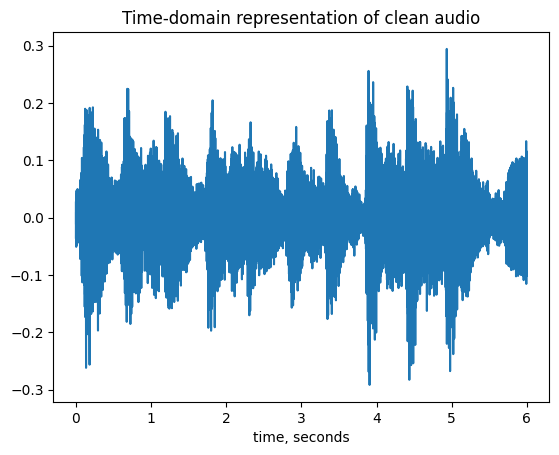

In [5]:
time = np.array(range(sample.shape[0])) / sampling_rate
plt.plot(time, sample)
plt.title('Time-domain representation of clean audio')
plt.xlabel('time, seconds')
plt.show()
Audio(sample, rate=sampling_rate)

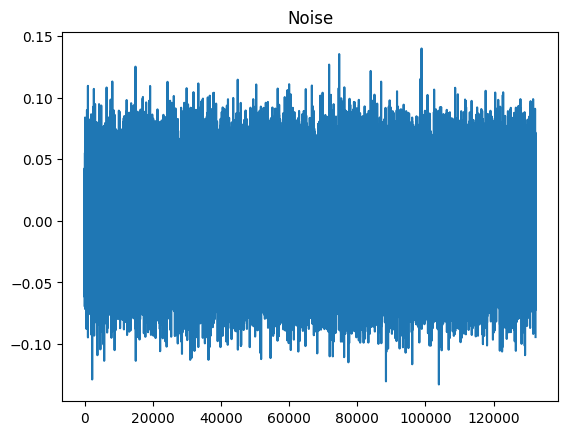

In [6]:
noise = np.random.normal(0, 0.03, sample.shape[0])

plt.plot(noise)
plt.title('Noise')
plt.show()

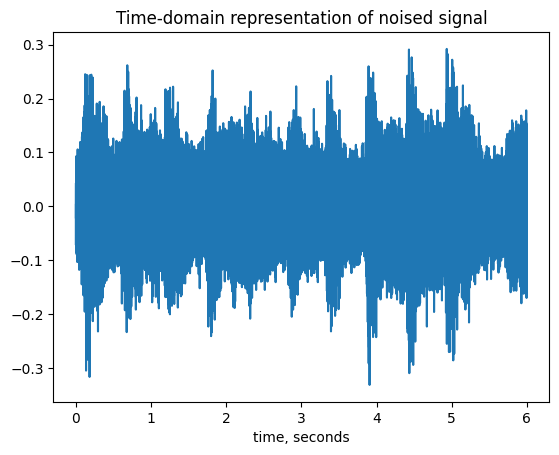

In [7]:
signal = sample + noise

plt.plot(time, signal)
plt.title('Time-domain representation of noised signal')
plt.xlabel('time, seconds')
plt.show()

Audio(signal, rate=sampling_rate)

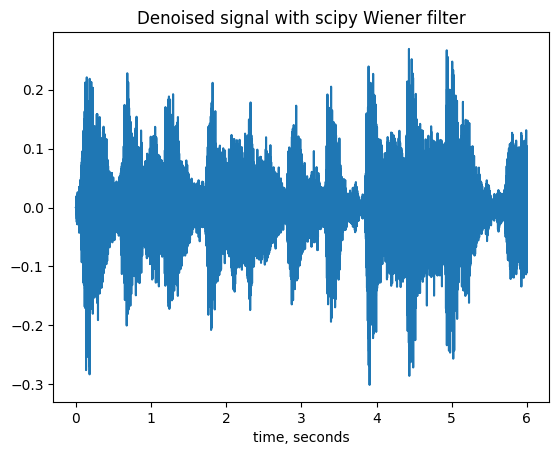

In [8]:
lib_wiener_filtered = wiener(signal, noise=np.var(noise), mysize=500)

plt.plot(time, lib_wiener_filtered)
plt.title('Denoised signal with scipy Wiener filter')
plt.xlabel('time, seconds')
plt.show()

Audio(lib_wiener_filtered, rate=sampling_rate)

In [132]:
def orthogonal_diag_inverse(matrix): #works much slower than inverse
    Q, D, Q_T = np.linalg.svd(matrix)
    D_inv = np.diag(D**-1)
    return Q@D_inv@Q_T


def optimal_filter(samples, noise):
    start = time.time()
    correlation = fftconvolve(samples, samples[::-1])
    rxx = correlation[correlation.size//2:]
    autocorrelation_matrix = toeplitz(rxx, rxx)
    rvv = fftconvolve(noise, noise[::-1])
    rvv = rvv[rvv.size//2:]
    cross_correlation_estimate = rxx - rvv
    end = time.time()
    print(f"Finding the matrix and vectors: {end-start}")
    # handmade, faster at small matrices
    start = time.time()
    filter = orthogonal_diag_inverse(autocorrelation_matrix)@cross_correlation_estimate 
    end = time.time()
    print(f"Finding the optimal filter: {end-start}")
    # built-in, faster at big matrices
    # filter = np.linalg.inv(autocorrelation_matrix)@cross_correlation_estimate
    return filter


def wiener_filter(last_samples, noise_sample):
    filter = optimal_filter(last_samples, noise_sample)
    return filter.transpose()@last_samples



In [133]:
windowsize = 100
filtered_us = np.zeros(signal.size)
for i in range(1, 500):
    filtered_us[i] = wiener_filter(signal[max(0, i-windowsize):i],
                                    noise[max(0, i-windowsize):i])

KeyboardInterrupt: 

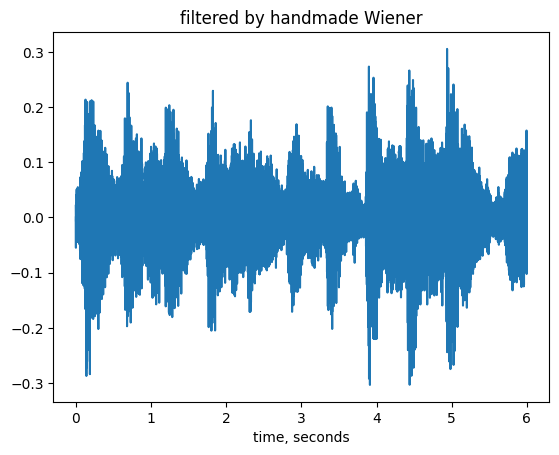

In [129]:
plt.plot(time, filtered_us)
plt.title("filtered by handmade Wiener")
plt.xlabel("time, seconds")
plt.show()
Audio(filtered_us, rate=sampling_rate)